# 캐글 신용 카드 사기 검출

## 언더샘플링과 오버 샘플링

### 언더 샘플링

- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식<br><br>

- 즉, 정상 레이블을 가진 데이터가 10000건, 이상 레이블을 가진 데이터가 100건이면 정상 데이터를 100건으로 줄이는 방식<br><br>

- 정상 레이블을 제대로 학습하지못하는 단점있음.

### 오버 샘플링

- 이상 데이터와 같이 적은 데이터 세트 증식하여 학습을 위한 충분한 데이터 확보하는 방법.<br><br>

- 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfiting)이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식한다.<br><br>

- 대표적인 방법으론 SMOTE방법이 있다.

- SMOTE방법이란 적은 데이터 세트에 있는 개별 데이터들의 K최근접 이웃(K Nearest Neighbor)를 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터 생성하는 방식

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('../datasets/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


#### 필요없는 Time함수 삭제

In [2]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop("Time", axis=1, inplace = True)
    return df_copy

In [3]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size = 0.3,
                                                        random_state = 0,
                                                        stratify = y_target)
    
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)

print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score, roc_auc_score
import numpy as np

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # f1 score 추가
    f1score = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    print('정확도(Accuracy): {0:.4f}, 정밀도(precision): {1:.4f}, 재현율(recall): {2:.4f}, F1(F1_score):{3:.4f}, ROC-AUC: {4:.4f}'.format(
        accuracy, precision, recall, f1score, roc_auc))
    

### 테스트 데이터로 학습

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85283    12]
 [   57    91]]
정확도(Accuracy): 0.9992, 정밀도(precision): 0.8835, 재현율(recall): 0.6149, F1(F1_score):0.7251, ROC-AUC: 0.9602


### LightGBM이용

In [8]:
def get_model_train_eval(model, feature_train = None, feature_test = None, target_train = None, target_test = None):
    model.fit(feature_train, target_train)
    pred = model.predict(feature_test)
    pred_proba = model.predict_proba(feature_test)[:, 1]
    
    get_clf_eval(target_test, pred, pred_proba)

In [9]:
from lightgbm import LGBMClassifier

# 불균형한 데이터 분포 가지고 있어 boost_from_average = False 해줘야함
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, 
                          n_jobs = -1, boost_from_average = False)

get_model_train_eval(lgbm_clf, feature_train = X_train, feature_test = X_test,
                     target_train = y_train, target_test = y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도(Accuracy): 0.9995, 정밀도(precision): 0.9573, 재현율(recall): 0.7568, F1(F1_score):0.8453, ROC-AUC: 0.9790


- 재현율과 ROC-AUC 상승

### 데이터 분포도 변환 후 모델 학습/예측/평가

<AxesSubplot:xlabel='Amount', ylabel='Density'>

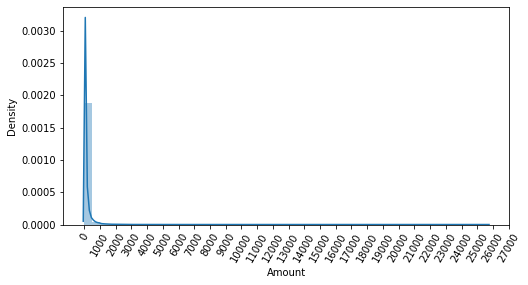

In [10]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

- 1000불 이하인 데이터가 대부분. 27000까지 데이터 존재

#### 표준정규분포 전처리

In [11]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피쳐명 변경후 dataframe맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

### 성능비교

In [12]:
from lightgbm import LGBMClassifier
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

print()
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   58    90]]
정확도(Accuracy): 0.9992, 정밀도(precision): 0.8654, 재현율(recall): 0.6081, F1(F1_score):0.7143, ROC-AUC: 0.9702

### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   37   111]]
정확도(Accuracy): 0.9995, 정밀도(precision): 0.9569, 재현율(recall): 0.7500, F1(F1_score):0.8409, ROC-AUC: 0.9779


### 로그변환 이용 전처리

- 로그 변환을 사용하면 상대적으로 작은 값으로 변환가능. 미분해주는 것과 같은 원리

In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [14]:
from lightgbm import LGBMClassifier
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

print()
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85283    12]
 [   59    89]]
정확도(Accuracy): 0.9992, 정밀도(precision): 0.8812, 재현율(recall): 0.6014, F1(F1_score):0.7149, ROC-AUC: 0.9727

### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   35   113]]
정확도(Accuracy): 0.9995, 정밀도(precision): 0.9576, 재현율(recall): 0.7635, F1(F1_score):0.8496, ROC-AUC: 0.9796


## 이상치 데이터 제거후 모델 학습/예측/평가

- 사분위수 이용해 이상치 데이터 검출

- IQR 방식 이용. (25% ~ 75%) 1/4 ~ 3/4 지점에 속하는 값들을 들고와서 일정 값을 주어 최대 최소 지정후 그값 이상이나 이하가 되면 이상값으로 처리

- 3/4 분위수에 * 1.5한게 최대값. 1/4분위수에 * 1.5한게 최솟값으로 가정. 꼭 1.5를 안써도 되나 통용되는 default값은 1.5임

<AxesSubplot:>

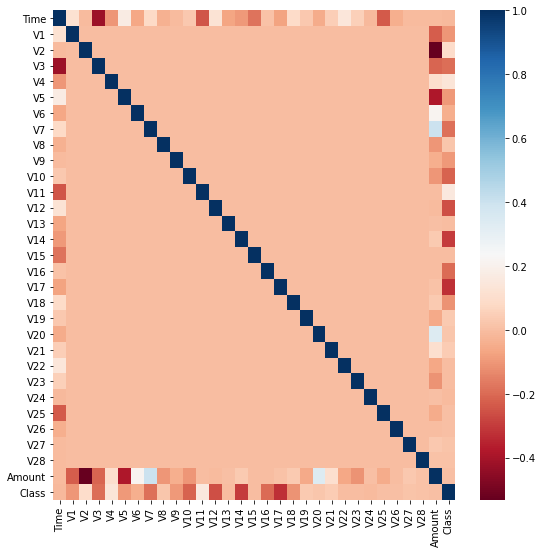

In [15]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap="RdBu")

- Class와 상관관계가 높아 보이는 피처는 V14, V17

In [16]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구한다.
    fraud = df[df["Class"] == 1][column]
    
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [17]:
outlier_index = get_outlier(df=card_df, column="V14", weight=1.5)
print("이상치 데이터 인덱스", outlier_index)

이상치 데이터 인덱스 Int64Index([8296, 8615, 9035, 9252], dtype='int64')


### 위의 이상치 인덱스 제거후 LightGBM 적용

In [18]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    
    # 이상치 데이터 삭제
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace=True)
    return df_copy

In [19]:
from lightgbm import LGBMClassifier
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

print()
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도(Accuracy): 0.9993, 정밀도(precision): 0.8750, 재현율(recall): 0.6712, F1(F1_score):0.7597, ROC-AUC: 0.9743

### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   25   121]]
정확도(Accuracy): 0.9996, 정밀도(precision): 0.9603, 재현율(recall): 0.8288, F1(F1_score):0.8897, ROC-AUC: 0.9780


- 재현율이 크게 증가함

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: ", X_train.shape, y_train.shape, "\n")
print("SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape, "\n")
print("SMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트:  (199362, 29) (199362,) 

SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트:  (398040, 29) (398040,) 

SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [22]:
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf, feature_train=X_train_over, feature_test=X_test, target_train=y_train_over, target_test=y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도(Accuracy): 0.9723, 정밀도(precision): 0.0542, 재현율(recall): 0.9247, F1(F1_score):0.1023, ROC-AUC: 0.9737


- 정밀도가 엄청떨어짐. 실제 데이터보다 많은 Class=1의 데이터를 학습시켜 정밀도가 떨어진것으로 보임

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()


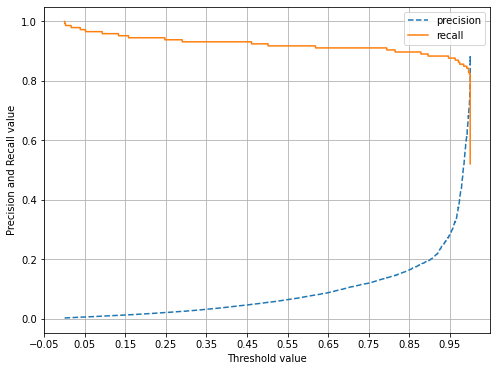

In [24]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### SMOTE LightGBM 모델로 학습

In [25]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, feature_train=X_train_over, feature_test=X_test, target_train=y_train_over, target_test=y_test)

오차행렬
[[85283    12]
 [   22   124]]
정확도(Accuracy): 0.9996, 정밀도(precision): 0.9118, 재현율(recall): 0.8493, F1(F1_score):0.8794, ROC-AUC: 0.9814
